In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'cencoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://erddap.cencoos.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2022/data/processed/%s.xlsx' % ra.upper(), dtype=str)
df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,CENCOOS,Trinidad,TDPC1,Trinidad Pier,Trinidad Shore Station,41.06,-124.15,fixed pier,2008-12-31 00:00:00,y,HSU/CeNCOOS,Yp,HSU,Academic,HSU,CeNCOOS/HSU,"sea_water_temperature(4.6m), sea_water_salinit...",Need to check variables
1,CENCOOS,Humboldt,HBXC1,Humboldt Bay: Chevron Dock,Chevron Dock Pier Station,40.78,-124.2,fixed pier,2003,y,HSU/CeNCOOS,yp,HSU,Academic,HSU,CeNCOOS/HSU,"sea_water_temperature(2m), sea_water_salinity(...",NaN
2,CENCOOS,Humboldt,N/A not real-time,Humboldt Bay: South Bay,Humboldt Bay South Bay Station,40.43,-124.13,fixed pier,2006-08-01 00:00:00,y,HSU/CeNCOOS,Yp,HSU,Academic,HSU,HSU,"sea_water_temperature(2m), sea_water_salinity(...",NaN
3,CENCOOS,Tuluwat Island,N/A was off line for a long time,Tuluwat Island,Tuluwat Island,40.81,-124.15,fixed pier,2015,y,Wiyot/CeNCOOS/HSU,Yp,Wiyot,Tribal,Wiyot,CeNCOOS/HSU,"sea_water_temperature(2.4m), sea_water_salini...",NaN
4,CENCOOS,HSU IFCB,N/A,HSU IFCB,HSU IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,HSU,Academic,HSU,NaN,NaN,NaN
5,CENCOOS,Kibesilla Hill,N/A not real-time,Kibisilla Hill,Kibesilla Hill Intertidal Station,39.6,-123.79,fixed intertidal,2007,n,SSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature, sea_water_ph_measured_o...",NaN
6,CENCOOS,Bodega Head,N/A not real-time,Bodega Head,Bodega Head intertidal station,38.32,-123.07,fixed intertidal,2007,n,SSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature, sea_water_ph_measured_o...",NaN
7,CENCOOS,Bodega,BDXC1,Bodega,Horeshoe cove BML Seawater Intake Station,38.32,-123.07,fixed intake,2003,y,UC Davis/CeNCOOS,yp,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature(2.9m), sea_water_salinit...",NaN
8,CENCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed pier,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN
9,CENCOOS,Tomales Bay,NaN,Tomales Bay,Tomales Bay Buoy,38.19,-122.93,moored buoy,2013-06-03 00:00:00,y,UC Davis/CeNCOOS,n,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature, sea_water_salinity, mas...",NaN


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [5]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [6]:
not_found = []
found = dict()

exclude = ' -gliders'

#search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

# GLOS
search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']
# SCCOOS
#search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']

for search1 in df[search_order[0]].astype(str):
    
    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "Trinidad"
Found "Trinidad": ['saic_thd', 'gov_usgs_waterdata_11481200', 'edu_humboldt_tdp']


searching "Station ID" = "Humboldt"
Found "Humboldt": ['miscwebcam_127', 'humboldt-bay-burkeolator', 'edu_ucsd_cdip_128', 'edu_ucsd_cdip_168', 'noaa_nos_co_ops_9418767', 'noaa_nos_co_ops_9418768', 'edu_humboldt_tdp', 'saic_hbc', 'wiyot_tribe_indianisland']


searching "Station ID" = "Humboldt"
Found "Humboldt": ['miscwebcam_127', 'humboldt-bay-burkeolator', 'edu_ucsd_cdip_128', 'edu_ucsd_cdip_168', 'noaa_nos_co_ops_9418767', 'noaa_nos_co_ops_9418768', 'edu_humboldt_tdp', 'saic_hbc', 'wiyot_tribe_indianisland']


searching "Station ID" = "Tuluwat Island"
Found "Tuluwat Island": ['wiyot_tribe_indianisland']


searching "Station ID" = "HSU IFCB"
no dataset matching "HSU IFCB"
searching "Station Long Name" = "HSU IFCB"
searching "WMO ID or NWS/CMAN ID" = "N/A "
Couldn't find: ['HSU IFCB', 'HSU IFCB', 'N/A ']


searching "Station ID" = "Kibesilla Hill"
Found "Kibesilla Hil

Print the stations that we couldn't find.

In [7]:
len(not_found)

5

In [8]:
len(found)

20

Show me the record that has NaN for the first search element.

In [9]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


Now show me the stations, with identifiers, that we couldn't find.

In [10]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
4,CENCOOS,HSU IFCB,N/A,HSU IFCB,HSU IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,HSU,Academic,HSU,NaN,NaN,NaN
8,CENCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed pier,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN
15,CENCOOS,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN
17,CENCOOS,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN
20,CENCOOS,IFCB161,NaN,IFCB161,IFCB161,NaN,NaN,moored buoy,2021-08-17 00:00:00,o,MBARI/CeNCOOS,Yp,NaN,nonprofit,MBARI,NaN,NaN,NaN


Print out all the dataset IDs for the datasets that matched our criteria.

In [11]:
found

{'Trinidad': {'Dataset ID': ['saic_thd',
   'gov_usgs_waterdata_11481200',
   'edu_humboldt_tdp']},
 'Humboldt': {'Dataset ID': ['miscwebcam_127',
   'humboldt-bay-burkeolator',
   'edu_ucsd_cdip_128',
   'edu_ucsd_cdip_168',
   'noaa_nos_co_ops_9418767',
   'noaa_nos_co_ops_9418768',
   'edu_humboldt_tdp',
   'saic_hbc',
   'wiyot_tribe_indianisland']},
 'Tuluwat Island': {'Dataset ID': ['wiyot_tribe_indianisland']},
 'Kibesilla Hill': {'Dataset ID': ['san_francisco_state_universit_kibesillah_hill_intertidal_shore_station']},
 'Bodega Head': {'Dataset ID': ['san_francisco_state_universit_bodega_head_intertidal_shore_station',
   'bodega-bay-bml_wts']},
 'Bodega  ': {'Dataset ID': ['gov_noaa_uscrn_1531',
   'wmo_46013',
   'san_francisco_state_universit_bodega_head_intertidal_shore_station',
   'bodega-marine-laboratory-bml-',
   'bodega-bay-bml_wts',
   'fort-point',
   'cordell-banks-mooring',
   'tomales-bay-buoy',
   'hog-island-hatchery']},
 'Tomales Bay': {'Dataset ID': ['tomales

Check if each found dataset has coverage for specified CY

In [12]:
valid_datasets = []

cy = '2022'

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "{}-01-01".format(cy)
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

Datasets without coverage for 2022:
{'Monterey Wharf', 'Kibesilla Hill', 'Tomales Bay', 'Tuluwat Island'}


Show me the inventory metadata about the invalid stations:

In [13]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,erddap_not_avail
3,CENCOOS,Tuluwat Island,N/A was off line for a long time,Tuluwat Island,Tuluwat Island,40.81,-124.15,fixed pier,2015,y,Wiyot/CeNCOOS/HSU,Yp,Wiyot,Tribal,Wiyot,CeNCOOS/HSU,"sea_water_temperature(2.4m), sea_water_salini...",NaN,True
4,CENCOOS,HSU IFCB,N/A,HSU IFCB,HSU IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,HSU,Academic,HSU,NaN,NaN,NaN,True
5,CENCOOS,Kibesilla Hill,N/A not real-time,Kibisilla Hill,Kibesilla Hill Intertidal Station,39.6,-123.79,fixed intertidal,2007,n,SSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature, sea_water_ph_measured_o...",NaN,True
8,CENCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed pier,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN,True
9,CENCOOS,Tomales Bay,NaN,Tomales Bay,Tomales Bay Buoy,38.19,-122.93,moored buoy,2013-06-03 00:00:00,y,UC Davis/CeNCOOS,n,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature, sea_water_salinity, mas...",NaN,True
15,CENCOOS,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,True
17,CENCOOS,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,True
20,CENCOOS,IFCB161,NaN,IFCB161,IFCB161,NaN,NaN,moored buoy,2021-08-17 00:00:00,o,MBARI/CeNCOOS,Yp,NaN,nonprofit,MBARI,NaN,NaN,NaN,True
21,CENCOOS,Monterey Wharf,MYXC1,Monterey Wharf,Monterey: Municipal Wharf II,36.61,-121.89,fixed pier,2015-05-04 00:00:00,o,MLML/SJSU/CeNCOOS,Yp,SJSU (MLML),Academic,SJSU (MLML),MLML,"sea_water_temperature(2.5m), sea_water_salinit...",NaN,True


Invert the `erddap_not_avail` column and drop it.

In [14]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,erddap_avail
0,CENCOOS,Trinidad,TDPC1,Trinidad Pier,Trinidad Shore Station,41.06,-124.15,fixed pier,2008-12-31 00:00:00,y,HSU/CeNCOOS,Yp,HSU,Academic,HSU,CeNCOOS/HSU,"sea_water_temperature(4.6m), sea_water_salinit...",Need to check variables,True
1,CENCOOS,Humboldt,HBXC1,Humboldt Bay: Chevron Dock,Chevron Dock Pier Station,40.78,-124.2,fixed pier,2003,y,HSU/CeNCOOS,yp,HSU,Academic,HSU,CeNCOOS/HSU,"sea_water_temperature(2m), sea_water_salinity(...",NaN,True
2,CENCOOS,Humboldt,N/A not real-time,Humboldt Bay: South Bay,Humboldt Bay South Bay Station,40.43,-124.13,fixed pier,2006-08-01 00:00:00,y,HSU/CeNCOOS,Yp,HSU,Academic,HSU,HSU,"sea_water_temperature(2m), sea_water_salinity(...",NaN,True
3,CENCOOS,Tuluwat Island,N/A was off line for a long time,Tuluwat Island,Tuluwat Island,40.81,-124.15,fixed pier,2015,y,Wiyot/CeNCOOS/HSU,Yp,Wiyot,Tribal,Wiyot,CeNCOOS/HSU,"sea_water_temperature(2.4m), sea_water_salini...",NaN,False
4,CENCOOS,HSU IFCB,N/A,HSU IFCB,HSU IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,HSU,Academic,HSU,NaN,NaN,NaN,False
5,CENCOOS,Kibesilla Hill,N/A not real-time,Kibisilla Hill,Kibesilla Hill Intertidal Station,39.6,-123.79,fixed intertidal,2007,n,SSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature, sea_water_ph_measured_o...",NaN,False
6,CENCOOS,Bodega Head,N/A not real-time,Bodega Head,Bodega Head intertidal station,38.32,-123.07,fixed intertidal,2007,n,SSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature, sea_water_ph_measured_o...",NaN,True
7,CENCOOS,Bodega,BDXC1,Bodega,Horeshoe cove BML Seawater Intake Station,38.32,-123.07,fixed intake,2003,y,UC Davis/CeNCOOS,yp,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature(2.9m), sea_water_salinit...",NaN,True
8,CENCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed pier,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN,False
9,CENCOOS,Tomales Bay,NaN,Tomales Bay,Tomales Bay Buoy,38.19,-122.93,moored buoy,2013-06-03 00:00:00,y,UC Davis/CeNCOOS,n,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature, sea_water_salinity, mas...",NaN,False


Make a plot of all points and color based on ERDDAP available or not.

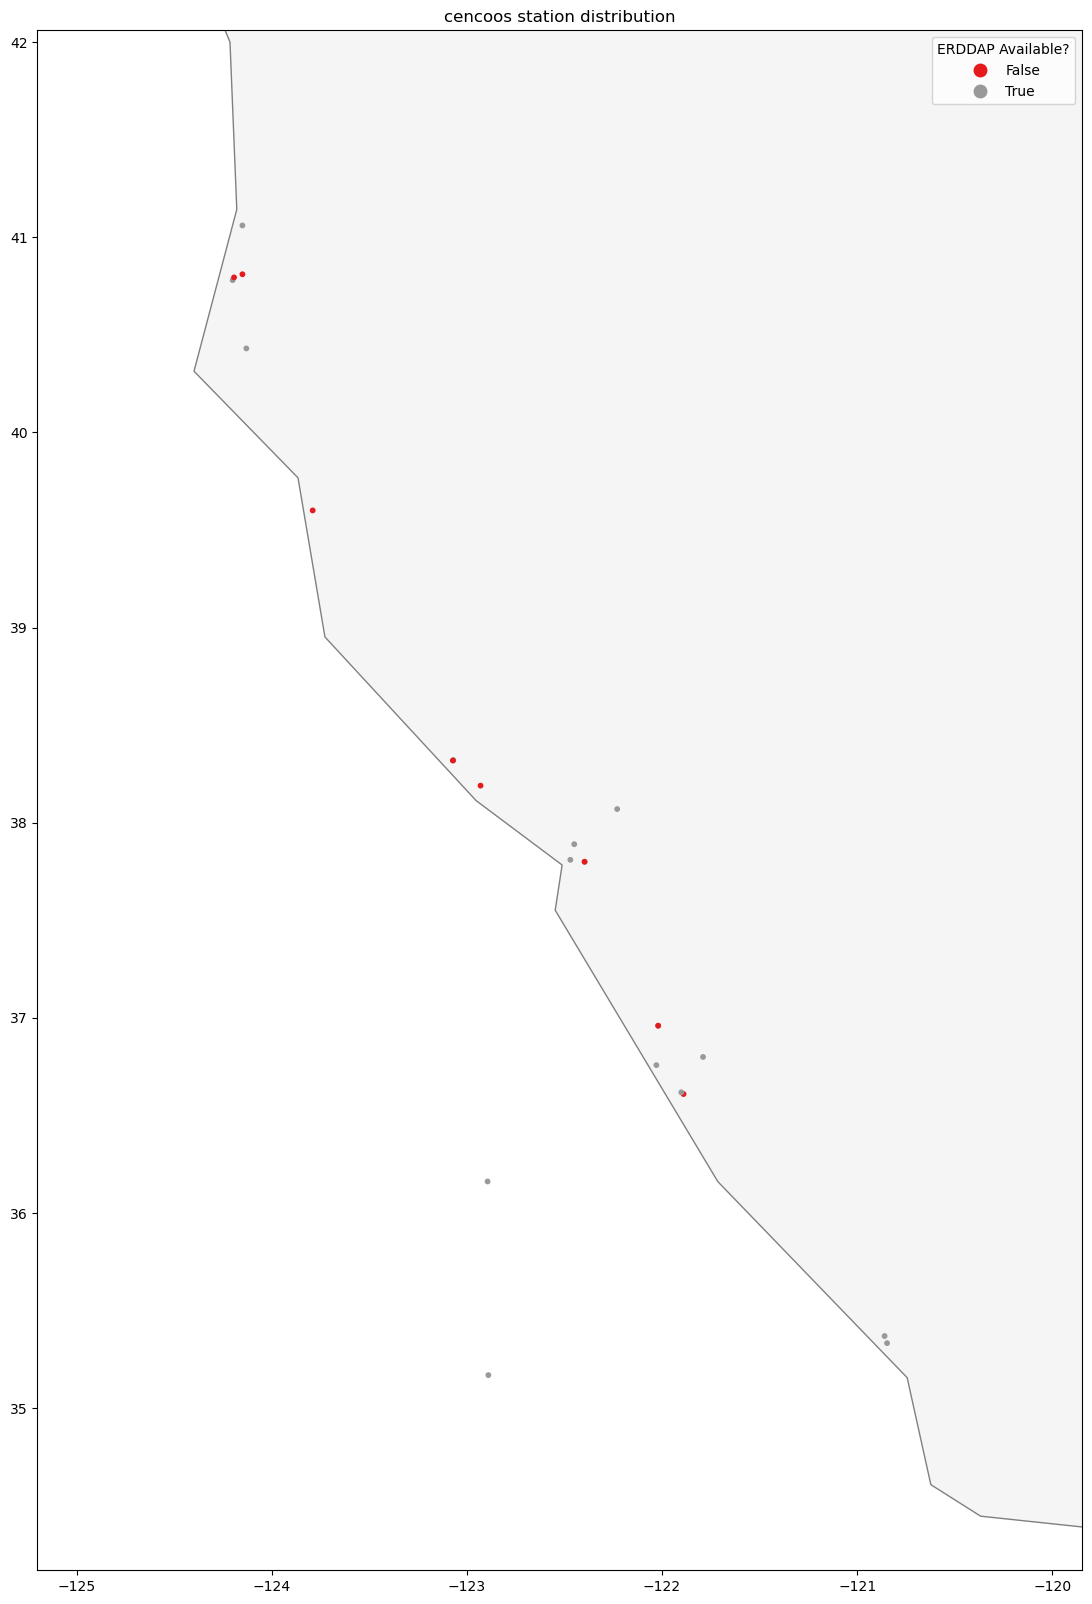

In [15]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [16]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1')


## Show me some bad coordinates

_if there are any_

In [17]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
20,CENCOOS,IFCB161,NaN,IFCB161,IFCB161,NaN,NaN,moored buoy,2021-08-17 00:00:00,o,MBARI/CeNCOOS,Yp,NaN,nonprofit,MBARI,NaN,NaN,NaN,False,POINT EMPTY


In [18]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [19]:
gdf_final.loc[~gdf_final['erddap_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
3,CENCOOS,Tuluwat Island,N/A was off line for a long time,Tuluwat Island,Tuluwat Island,40.81,-124.15,fixed pier,2015,y,Wiyot/CeNCOOS/HSU,Yp,Wiyot,Tribal,Wiyot,CeNCOOS/HSU,"sea_water_temperature(2.4m), sea_water_salini...",NaN,False,POINT (-124.15000 40.81000)
4,CENCOOS,HSU IFCB,N/A,HSU IFCB,HSU IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,HSU,Academic,HSU,NaN,NaN,NaN,False,POINT (-124.19289 40.79394)
5,CENCOOS,Kibesilla Hill,N/A not real-time,Kibisilla Hill,Kibesilla Hill Intertidal Station,39.6,-123.79,fixed intertidal,2007,n,SSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature, sea_water_ph_measured_o...",NaN,False,POINT (-123.79000 39.60000)
8,CENCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed pier,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN,False,POINT (-123.07160 38.31850)
9,CENCOOS,Tomales Bay,NaN,Tomales Bay,Tomales Bay Buoy,38.19,-122.93,moored buoy,2013-06-03 00:00:00,y,UC Davis/CeNCOOS,n,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature, sea_water_salinity, mas...",NaN,False,POINT (-122.93000 38.19000)
15,CENCOOS,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,False,POINT (-122.39700 37.80000)
17,CENCOOS,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,False,POINT (-122.02000 36.96000)
20,CENCOOS,IFCB161,NaN,IFCB161,IFCB161,NaN,NaN,moored buoy,2021-08-17 00:00:00,o,MBARI/CeNCOOS,Yp,NaN,nonprofit,MBARI,NaN,NaN,NaN,False,POINT EMPTY
21,CENCOOS,Monterey Wharf,MYXC1,Monterey Wharf,Monterey: Municipal Wharf II,36.61,-121.89,fixed pier,2015-05-04 00:00:00,o,MLML/SJSU/CeNCOOS,Yp,SJSU (MLML),Academic,SJSU (MLML),MLML,"sea_water_temperature(2.5m), sea_water_salinit...",NaN,False,POINT (-121.89000 36.61000)


# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [20]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]


for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Station "tuluwat island" + RA "cencoos"
Query: https://data.ioos.us/dataset/?q="tuluwat%20island"%20-glider&organization=cencoos
	found 1 dataset(s):
	 * CeNCOOS in situ water quality monitoring at Tuluwat (Indian Island).
	 https://erddap.cencoos.org/erddap/tabledap/wiyot_tribe_indianisland
	 Coverage Meta:
		 2016-04-01T00:15:00Z  -  2020-12-17T10:45:00Z 

	Tuluwat Island is not valid.
Station "hsu ifcb" + RA "cencoos"
Query: https://data.ioos.us/dataset/?q="hsu%20ifcb"%20-glider&organization=cencoos
	No datasets found!
Station "kibesilla hill" + RA "cencoos"
Query: https://data.ioos.us/dataset/?q="kibesilla%20hill"%20-glider&organization=cencoos
	No datasets found!
Station "ifcb163" + RA "cencoos"
Query: https://data.ioos.us/dataset/?q="ifcb163"%20-glider&organization=cencoos
	No datasets found!
Station "tomales bay" + RA "cencoos"
Query: https://data.ioos.us/dataset/?q="tomales%20bay"%20-glider&organization=cencoos
	found 1 dataset(s):
	 Tomales Bay Buoy
	 https://erddap.cencoos.or

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [21]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
3,CENCOOS,Tuluwat Island,N/A was off line for a long time,Tuluwat Island,Tuluwat Island,40.81,-124.15,fixed pier,2015,y,Wiyot/CeNCOOS/HSU,Yp,Wiyot,Tribal,Wiyot,CeNCOOS/HSU,"sea_water_temperature(2.4m), sea_water_salini...",NaN,False,POINT (-124.15000 40.81000)
4,CENCOOS,HSU IFCB,N/A,HSU IFCB,HSU IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,HSU,Academic,HSU,NaN,NaN,NaN,False,POINT (-124.19289 40.79394)
5,CENCOOS,Kibesilla Hill,N/A not real-time,Kibisilla Hill,Kibesilla Hill Intertidal Station,39.6,-123.79,fixed intertidal,2007,n,SSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature, sea_water_ph_measured_o...",NaN,False,POINT (-123.79000 39.60000)
8,CENCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed pier,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN,False,POINT (-123.07160 38.31850)
9,CENCOOS,Tomales Bay,NaN,Tomales Bay,Tomales Bay Buoy,38.19,-122.93,moored buoy,2013-06-03 00:00:00,y,UC Davis/CeNCOOS,n,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature, sea_water_salinity, mas...",NaN,False,POINT (-122.93000 38.19000)
15,CENCOOS,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,False,POINT (-122.39700 37.80000)
17,CENCOOS,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,False,POINT (-122.02000 36.96000)
20,CENCOOS,IFCB161,NaN,IFCB161,IFCB161,NaN,NaN,moored buoy,2021-08-17 00:00:00,o,MBARI/CeNCOOS,Yp,NaN,nonprofit,MBARI,NaN,NaN,NaN,False,POINT EMPTY
21,CENCOOS,Monterey Wharf,MYXC1,Monterey Wharf,Monterey: Municipal Wharf II,36.61,-121.89,fixed pier,2015-05-04 00:00:00,o,MLML/SJSU/CeNCOOS,Yp,SJSU (MLML),Academic,SJSU (MLML),MLML,"sea_water_temperature(2.5m), sea_water_salinit...",NaN,False,POINT (-121.89000 36.61000)


Print out the available metadata from the IOOS Catalog for the last dataset.

In [22]:
dataset

{'author': None,
 'author_email': None,
 'creator_user_id': 'bb55ba1f-9c92-4539-a676-e1fea85df891',
 'id': '81efb8dd-f5e9-47e0-b093-32f8e2ab6194',
 'isopen': False,
 'license_id': None,
 'license_title': None,
 'maintainer': None,
 'maintainer_email': None,
 'metadata_created': '2023-01-18T04:58:59.222113',
 'metadata_modified': '2023-03-09T00:59:29.077588',
 'name': 'cencoos-in-situ-water-quality-monitoring-at-monterey-bay-commercial-wharf',
 'notes': 'The Monterey shore station is maintained by Moss Landing Marine Labs. The station has been operational since 2012 and consists of in water sensors that are fixed to a pier sampling every 15 minutes. These sensors provide near-real time observations of ocean water salinity, temperature, dissolved oxygen, chlorophyll fluorescence, turbidity and pH. These sensors provide near-real time observations of ocean water conductivity, salinity, temperature, depth, dissolved oxygen, chlorophyll fluorescence, turbidity and nitrate. These nearshore s

In [23]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [24]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]